In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from loadData import *
from ML_util import *


device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
learning_rate = 0.001
training_epochs = 400
batch_size = 32
# print(device)
# print(torch.version.cuda)

In [27]:

class IdentiGazeDataset(Dataset):
    def __init__(self, path, dataType) -> None:
        super().__init__()
        self.loadSelectiveData = LoadResultData(path)
        if dataType == 'train':
            self.data = self.loadSelectiveData.take_df_by_session([1,2,3,4]).reset_index(drop=True)
            # self.data = self.loadSelectiveData.take_df_by_session([1,2,3,4]).reset_index(drop=True)
        elif dataType == 'test':
            self.data = self.loadSelectiveData.take_df_by_session([5]).reset_index(drop=True)

        self.rawgaze = self.loadSelectiveData.take_xy2d(self.data)
        self.eyemovement = self.loadSelectiveData.take_EyeMovement(self.data)
        self.fixation = self.loadSelectiveData.take_Fixation(self.data)
        self.saccade = self.loadSelectiveData.take_Saccade(self.data)
        self.MFCC = self.loadSelectiveData.take_MFCC(self.data)
        self.pupil = self.loadSelectiveData.take_Pupil(self.data)
        self.y = self.loadSelectiveData.take_y(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        rawgaze = torch.FloatTensor(self.rawgaze.iloc[index]).transpose(0,1)
        eyemovement = torch.FloatTensor(self.eyemovement.iloc[index])
        fixation = torch.FloatTensor(self.fixation.iloc[index])
        saccade = torch.FloatTensor(self.saccade.iloc[index])
        mfcc = torch.FloatTensor(self.MFCC.iloc[index])
        pupil = torch.FloatTensor(self.pupil.iloc[index])
        label = self.y.iloc[index]
        return {'rawgaze':rawgaze, 'eyemovement':eyemovement, 'fixation':fixation, 'saccade': saccade, 
                'mfcc': mfcc, 'pupil': pupil, 'y': label}




In [28]:
path = 'C:\\Users\\scilab\\IdentiGaze\\data\\DayDifference\\Similar_All.csv'
trainDataset = IdentiGazeDataset(path, 'train')
testDataset = IdentiGazeDataset(path, 'test')

In [60]:
trainDataset[3]

C:\Users\scilab\AppData\Local\Temp\ipykernel_33056\2358772431.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eyemovement = torch.FloatTensor(self.eyemovement.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_33056\2358772431.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fixation = torch.FloatTensor(self.fixation.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_33056\2358772431.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

{'rawgaze': tensor([[ 898.,  896.,  903.,  905.,  906.,  902.,  907.,  905.,  905.,  907.,
           909.,  909.,  906.,  905.,  906.,  907.,  906.,  906.,  904.,  903.,
           901.,  902.,  902.,  902.,  902.,  900.,  898.,  896.,  898.,  898.,
           896.,  899.,  898.,  900.,  896.,  897.,  897.,  896.,  896.,  895.,
           895.,  896.,  897.,  899.,  896.,  886.,  840.,  793.,  774.,  773.,
           775.,  773.,  775.,  775.,  770.,  770.,  769.,  774.,  769.,  771.,
           768.,  767.,  770.,  768.,  768.,  766.,  770.,  798.,  856.,  944.,
          1030., 1094., 1145., 1148., 1142., 1152., 1149., 1151., 1154., 1152.,
          1149., 1153., 1155., 1159.],
         [ 288.,  277.,  287.,  291.,  292.,  292.,  289.,  292.,  291.,  291.,
           292.,  293.,  289.,  291.,  291.,  288.,  288.,  285.,  287.,  285.,
           290.,  286.,  284.,  286.,  286.,  288.,  289.,  291.,  289.,  288.,
           292.,  287.,  289.,  288.,  288.,  290.,  288.,  288.,  292

<h1> AgeNET

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv1d(x)
        return x[:, :, :-self.padding]  # Remove the padding on the right

class GatedActivationUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(GatedActivationUnit, self).__init__()
        self.conv = CausalConv1d(in_channels, out_channels * 2, kernel_size, stride, dilation)

    def forward(self, x):
        x = self.conv(x)
        out, gate = x.chunk(2, dim=1)  # Split the tensor along the channel dimension
        return torch.tanh(out) * torch.sigmoid(gate)  # Gated activation


class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.dropout = nn.Dropout(0.2)

        # Define the gated convolutional layers
        self.conv1 = GatedActivationUnit(2, 4, kernel_size=7, stride=1, dilation=2)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.conv2 = GatedActivationUnit(4, 5, kernel_size=5, stride=1, dilation=4)
        self.conv3 = GatedActivationUnit(5, 16, kernel_size=3, stride=1, dilation=5)
        self.conv4 = GatedActivationUnit(16, 32, kernel_size=3, stride=1, dilation=16)
        self.pool2 = nn.AdaptiveMaxPool1d(1)  # Global Max Pooling

        # Define the fully connected layers
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 128)

        # Define the output layer
        self.output = nn.Linear(128, 34)

    def forward(self, x):
        # Apply the gated convolutions
        x = self.conv1(x)
        print(x.shape)
        x = self.pool1(x)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = self.conv3(x)
        print(x.shape)
        x = self.conv4(x)
        print(x.shape)
        # Apply global max pooling
        x = self.pool2(x)
        print(x.shape)
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        # Apply the output layer
        x = self.output(x)

        return x




In [26]:
# Instantiate the AgeNet model
model = AgeNet()

# Display the model architecture
output = model(torch.randn(1,2,84).to(device))
print(output.shape)

torch.Size([1, 4, 84])
torch.Size([1, 4, 28])
torch.Size([1, 5, 28])
torch.Size([1, 16, 28])
torch.Size([1, 32, 28])
torch.Size([1, 32, 1])
torch.Size([1, 34])


In [24]:
model

AgeNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): GatedActivationUnit(
    (conv): CausalConv1d(
      (conv1d): Conv1d(2, 8, kernel_size=(7,), stride=(1,), padding=(12,), dilation=(2,))
    )
  )
  (pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): GatedActivationUnit(
    (conv): CausalConv1d(
      (conv1d): Conv1d(4, 10, kernel_size=(5,), stride=(1,), padding=(16,), dilation=(4,))
    )
  )
  (conv3): GatedActivationUnit(
    (conv): CausalConv1d(
      (conv1d): Conv1d(5, 32, kernel_size=(3,), stride=(1,), padding=(10,), dilation=(5,))
    )
  )
  (conv4): GatedActivationUnit(
    (conv): CausalConv1d(
      (conv1d): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(16,))
    )
  )
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=34, bias=T

In [30]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

test_size = len(testDataset)
train_size = int(len(trainDataset)*0.8)
valid_size = len(trainDataset) - train_size
train_dataset, valid_dataset = random_split(trainDataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

In [133]:
for epoch in range(training_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        x_train = data['rawgaze'].to(device).type(dtype=torch.float32)
        y_train = data['y'].to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 30 == 29:
            print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
    
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            x_test = data['rawgaze'].to(device).type(dtype=torch.float32)
            y_test = data['y'].to(device)
            # calculate outputs by running images through the network
            outputs = model(x_test)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    torch.save(model.state_dict(), f'model/agenet/{epoch}_{100 * correct // total}.pth')


C:\Users\scilab\AppData\Local\Temp\ipykernel_33056\2358772431.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eyemovement = torch.FloatTensor(self.eyemovement.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_33056\2358772431.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fixation = torch.FloatTensor(self.fixation.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_33056\2358772431.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

[1,    30] loss: 0.025
[1,    60] loss: 0.027
[1,    90] loss: 0.024
[1,   120] loss: 0.026
[1,   150] loss: 0.024
[1,   180] loss: 0.026
[1,   210] loss: 0.026
[1,   240] loss: 0.027
[1,   270] loss: 0.025
[1,   300] loss: 0.027
[1,   330] loss: 0.027
[1,   360] loss: 0.025
[1,   390] loss: 0.026
[1,   420] loss: 0.027
[1,   450] loss: 0.027
[1,   480] loss: 0.028
[1,   510] loss: 0.027
[1,   540] loss: 0.026
[1,   570] loss: 0.028
[1,   600] loss: 0.026
[1,   630] loss: 0.026
[1,   660] loss: 0.026
[1,   690] loss: 0.027
[1,   720] loss: 0.028
[1,   750] loss: 0.027
[1,   780] loss: 0.026
[1,   810] loss: 0.026
Accuracy of the network on the 10000 test images: 39 %
[2,    30] loss: 0.025
[2,    60] loss: 0.025
[2,    90] loss: 0.026
[2,   120] loss: 0.026
[2,   150] loss: 0.026
[2,   180] loss: 0.026
[2,   210] loss: 0.025
[2,   240] loss: 0.025
[2,   270] loss: 0.028
[2,   300] loss: 0.025
[2,   330] loss: 0.026
[2,   360] loss: 0.026
[2,   390] loss: 0.025
[2,   420] loss: 0.027
[2

KeyboardInterrupt: 

<H1> Mixed Net

In [3]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv1d(x)
        return x[:, :, :-self.padding]  # Remove the padding on the right

class GatedActivationUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(GatedActivationUnit, self).__init__()
        self.conv = CausalConv1d(in_channels, out_channels * 2, kernel_size, stride, dilation)

    def forward(self, x):
        x = self.conv(x)
        out, gate = x.chunk(2, dim=1)  # Split the tensor along the channel dimension
        return torch.tanh(out) * torch.sigmoid(gate)  # Gated activation


In [31]:
class IdentiGazeNet(nn.Module):
    def __init__(self):
        super(IdentiGazeNet, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 128)
        # Define the output layer
        self.output = nn.Linear(128, 34)

        self.RawGazeNet = nn.Sequential(
            # Input Size: (84,2)
            CausalConv1d(2, 4, kernel_size=7, stride=1, dilation=2),
            nn.MaxPool1d(kernel_size=3, stride=3),
            CausalConv1d(4, 5, kernel_size=5, stride=1, dilation=4),
            CausalConv1d(5, 16, kernel_size=3, stride=1, dilation=5),
            CausalConv1d(16, 32, kernel_size=3, stride=1, dilation=16),
            nn.AdaptiveMaxPool1d(1),  # Global Max Pooling
        )

        self.EyeMovementNet = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 34)
        )

        self.FixationNet = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 34)
        )

        self.SaccadeNet = nn.Sequential(
            nn.Linear(17, 64),
            nn.ReLU(),
            nn.Linear(64, 34)
        )

        self.MFCCNet = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 34)
        )

        self.PupilNet = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 34)
        )


    def forward(self, rawgaze, eyemovement, fixation, saccade, mfcc, pupil):
        # Apply the gated convolutions
        rawgaze = self.RawGazeNet(rawgaze)
        rawgaze = rawgaze.view(rawgaze.size(0), -1)
        rawgaze = F.relu(self.fc1(rawgaze))
        rawgaze = self.dropout(rawgaze)
        rawgaze = F.relu(self.fc2(rawgaze))
        rawgaze = self.output(rawgaze)

        eyemovement = eyemovement.view(eyemovement.size(0), -1)
        eyemovement = self.EyeMovementNet(eyemovement)
        fixation = self.FixationNet(fixation)
        saccade = self.SaccadeNet(saccade)
        mfcc = self.MFCCNet(mfcc)
        pupil = self.PupilNet(pupil)

        out = rawgaze + eyemovement + fixation + saccade + mfcc + pupil
        return out


In [39]:
writer = SummaryWriter('model/IdNet3/runs')
idModel = IdentiGazeNet()
output = idModel(torch.randn(1,2,84).to(device), torch.randn(1,9).to(device),torch.randn(1,10).to(device),torch.randn(1,17).to(device),torch.randn(1,12).to(device),torch.randn(1,12).to(device))
# print(len(myIdentiGaze))
print(output.shape)

torch.Size([1, 34])


In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(idModel.parameters(), lr=learning_rate, weight_decay=1e-5)

In [12]:
train_size = len(trainDataset)
valid_size = len(validDataset)
test_size = len(testDataset)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validDataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

In [41]:
for epoch in range(training_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader):
        rawgaze = data['rawgaze'].to(device).type(dtype=torch.float32)
        eyemovement = data['eyemovement'].to(device).type(dtype=torch.float32)
        fixation = data['fixation'].to(device).type(dtype=torch.float32)
        saccade = data['saccade'].to(device).type(dtype=torch.float32)
        mfcc = data['mfcc'].to(device).type(dtype=torch.float32)
        pupil = data['pupil'].to(device).type(dtype=torch.float32)
        y = data['y'].to(device)
        
        optimizer.zero_grad()
        outputs = idModel(rawgaze, eyemovement, fixation, saccade, mfcc, pupil)
        loss = criterion(outputs, y)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    Accuracy = 100 * correct // total
    writer.add_scalar('Acc/train', Accuracy, epoch+1)
    writer.add_scalar('Loss/train', running_loss, epoch+1)
    running_loss = 0.0

    
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valid_loader:
            rawgaze = data['rawgaze'].to(device).type(dtype=torch.float32)
            eyemovement = data['eyemovement'].to(device).type(dtype=torch.float32)
            fixation = data['fixation'].to(device).type(dtype=torch.float32)
            saccade = data['saccade'].to(device).type(dtype=torch.float32)
            mfcc = data['mfcc'].to(device).type(dtype=torch.float32)
            pupil = data['pupil'].to(device).type(dtype=torch.float32)
            y = data['y'].to(device)
            # calculate outputs by running images through the network
            outputs = idModel(rawgaze, eyemovement, fixation, saccade, mfcc, pupil)
            test_loss = criterion(outputs, y)
            writer.add_scalar('Loss/valid', test_loss, epoch+1)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        Accuracy = 100 * correct // total
        print(f'Accuracy of the network on the 10000 test images: {Accuracy} %')
        writer.add_scalar('Acc/valid', Accuracy, epoch+1)
        torch.save(idModel.state_dict(), f'model/IdNet3/{epoch}_{100 * correct // total}.pth')


C:\Users\scilab\AppData\Local\Temp\ipykernel_25020\4154416870.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eyemovement = torch.FloatTensor(self.eyemovement.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_25020\4154416870.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fixation = torch.FloatTensor(self.fixation.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_25020\4154416870.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Accuracy of the network on the 10000 test images: 12 %
Accuracy of the network on the 10000 test images: 15 %
Accuracy of the network on the 10000 test images: 17 %
Accuracy of the network on the 10000 test images: 21 %
Accuracy of the network on the 10000 test images: 25 %
Accuracy of the network on the 10000 test images: 28 %
Accuracy of the network on the 10000 test images: 26 %
Accuracy of the network on the 10000 test images: 23 %
Accuracy of the network on the 10000 test images: 28 %
Accuracy of the network on the 10000 test images: 32 %
Accuracy of the network on the 10000 test images: 33 %
Accuracy of the network on the 10000 test images: 34 %
Accuracy of the network on the 10000 test images: 41 %
Accuracy of the network on the 10000 test images: 39 %
Accuracy of the network on the 10000 test images: 47 %
Accuracy of the network on the 10000 test images: 46 %
Accuracy of the network on the 10000 test images: 49 %
Accuracy of the network on the 10000 test images: 49 %
Accuracy o

In [9]:
torch.save(IdentiGazeAgeNet.state_dict(), 'ml-results/DL/IdentiGazenet3.pth')

In [42]:
# load_bestModel = AgeNet()
# load_bestModel.load_state_dict(torch.load('ml-results/DL/IdentiGazenet39_31.pth'))
# load_bestModel.to(device)
# load_bestModel.eval()
load_bestModel = IdentiGazeNet()
load_bestModel.load_state_dict(torch.load('model/IdNet3/399_77.pth'))
load_bestModel.to(device)
load_bestModel.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        rawgaze = data['rawgaze'].to(device).type(dtype=torch.float32)
        eyemovement = data['eyemovement'].to(device).type(dtype=torch.float32)
        fixation = data['fixation'].to(device).type(dtype=torch.float32)
        saccade = data['saccade'].to(device).type(dtype=torch.float32)
        mfcc = data['mfcc'].to(device).type(dtype=torch.float32)
        pupil = data['pupil'].to(device).type(dtype=torch.float32)
        y = data['y'].to(device)
        # calculate outputs by running images through the network
        outputs = load_bestModel(rawgaze, eyemovement, fixation, saccade, mfcc, pupil)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

C:\Users\scilab\AppData\Local\Temp\ipykernel_25020\4154416870.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eyemovement = torch.FloatTensor(self.eyemovement.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_25020\4154416870.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fixation = torch.FloatTensor(self.fixation.iloc[index])
C:\Users\scilab\AppData\Local\Temp\ipykernel_25020\4154416870.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

Accuracy of the network on the 10000 test images: 69 %


In [42]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in range(13)}
total_pred = {classname: 0 for classname in range(13)}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        x_test = data['x'].to(device).type(dtype=torch.float32)
        image_test = data['image'].to(device).type(dtype=torch.float32)
        y_test = data['y'].to(device)
        # calculate outputs by running images through the network
        outputs = IdentiGazeNet(image_test, x_test)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(y_test, predictions):
            if label == prediction:
                correct_pred[int(label)] += 1
            total_pred[int(label)] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 12.7 %
Accuracy for class: 1 is 24.3 %
Accuracy for class: 2 is 40.0 %
Accuracy for class: 3 is 16.5 %
Accuracy for class: 4 is 36.5 %
Accuracy for class: 5 is 18.5 %
Accuracy for class: 6 is 16.3 %
Accuracy for class: 7 is 54.2 %
Accuracy for class: 8 is 45.8 %
Accuracy for class: 9 is 31.8 %
Accuracy for class: 10 is 30.6 %
Accuracy for class: 11 is 27.0 %
Accuracy for class: 12 is 60.6 %


In [43]:
dataiter = iter(test_loader)
data_test = next(dataiter)
x_test = data_test['x'].to(device).type(dtype=torch.float32)
image_test = data_test['image'].to(device).type(dtype=torch.float32)
y_test = data_test['y'].to(device)
print('GroundTruth: ', ' '.join(f'{y_test[j]}' for j in range(20)))
outputs = IdentiGazeNet(image_test, x_test)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{predicted[j]}' for j in range (20)))

GroundTruth:  12 12 3 4 4 9 9 10 2 9 12 0 5 6 5 10 12 3 3 7
Predicted:  7 12 12 4 4 5 9 11 1 4 10 5 1 2 6 10 12 10 4 7


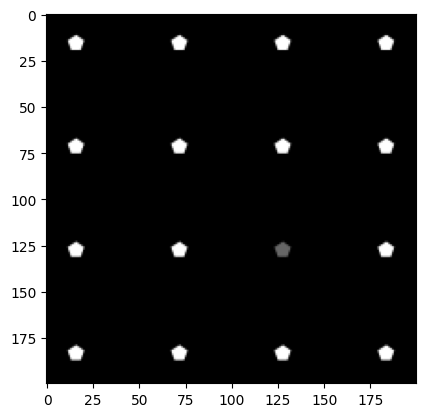

145


In [42]:
x1, image1, y1 = myIdentiGaze.__getitem__(1521)
exampleimage = np.array(image1, dtype=np.uint8)
plt.imshow(exampleimage)
plt.show()
print(len(x1))